### project3_5_Tfidvectorization.ipynb, 

wherein I try different choices in preprocessing: TfidVectorizer instead of CountVectorizer, stemming, and lemmatizing.

In [3]:
# import libraries:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer




Read in my data and other dataframes (including previous scores) - 

In [93]:
df = pd.read_csv('./data/redditcomments.csv')
df.drop(columns='Unnamed: 0',inplace=True)
df.dropna(inplace=True)
df['char_length'] = [len(comment) for comment in list(df['comment'])]
df = df[(df['char_length']>=10) & (df['char_length']<1000)]
df.head()

,comment,date,types,char_length
0,I think it's the end of the first episode rath...,1615999558,fantasy,76
1,I think you mean the prologue of the Wheel of ...,1615999475,fantasy,87
2,"Not properly ""Fantasy"", but ""Horus Rising"" ope...",1615999395,fantasy,218
3,Love that trilogy. Bit slow to get started (af...,1615999383,fantasy,85
4,&gt;At this point I think Sanderson being the ...,1615999332,fantasy,566


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18746 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      18746 non-null  object
 1   date         18746 non-null  int64 
 2   types        18746 non-null  object
 3   char_length  18746 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 732.3+ KB


In [ ]:
comments = list(df['comment'])
df['flagged'] = [1 if ('removed' in comment.split(' ')) else 0 for comment in comments]
df = df[df['flagged']==0]

In [95]:
stops_df = pd.read_csv('./data/stopwords.csv')
stops = list(stops_df['0'])
stops

['thick',
 'beyond',
 'six',
 'hereafter',
 'both',
 'her',
 'am',
 'forty',
 'very',
 'its',
 'above',
 'ours',
 'who',
 'someone',
 'might',
 'whenever',
 'per',
 'un',
 'may',
 'cannot',
 'formerly',
 'before',
 'up',
 'of',
 'amongst',
 'couldnt',
 'more',
 'four',
 'it',
 'thereupon',
 'there',
 'again',
 'him',
 'beside',
 'they',
 'less',
 'us',
 'hasnt',
 'in',
 'while',
 'one',
 'seeming',
 'had',
 'several',
 'thereafter',
 'since',
 'ten',
 'for',
 'too',
 'been',
 'de',
 'etc',
 'herself',
 'wherein',
 'herein',
 'during',
 'such',
 'noone',
 'yours',
 'serious',
 'whether',
 'enough',
 'whoever',
 'cant',
 'must',
 'eg',
 'otherwise',
 'itself',
 'get',
 'them',
 'why',
 'few',
 'nobody',
 'rather',
 'between',
 'ourselves',
 'fill',
 'below',
 'are',
 'indeed',
 'mine',
 'still',
 'perhaps',
 'thence',
 'most',
 'others',
 'no',
 'go',
 'then',
 'inc',
 'have',
 'hers',
 'twenty',
 'this',
 'full',
 'me',
 'either',
 'side',
 'onto',
 'five',
 'latterly',
 'con',
 'except

In [87]:
predictions = pd.read_csv('./data/predictions.csv')
predictions.drop(columns = 'Unnamed: 0', inplace=True)
predictions.head()

,types,Simple NB,Simple LR,LR 5000 features
0,fantasy,fantasy,fantasy,fantasy
1,fantasy,fantasy,fantasy,fantasy
2,scifi,scifi,scifi,scifi
3,scifi,scifi,scifi,scifi
4,scifi,scifi,scifi,scifi


In [88]:
predicted_probabilities = pd.read_csv('./data/predicted_probabilities.csv')
predicted_probabilities.drop(columns = 'Unnamed: 0', inplace=True)
predicted_probabilities.head()

,types,prediction,err type,err label,probability
0,0,0,0,"fantasy, correct",2.081928e-01
1,0,0,0,"fantasy, correct",2.242084e-08
2,1,1,3,"scifi, correct",9.309696e-01
3,1,1,3,"scifi, correct",9.962833e-01
4,1,1,3,"scifi, correct",7.649797e-01


In [97]:
scores = pd.read_csv('./data/scores.csv')
scores.drop(columns='ndx',inplace=True)
scores

,model,train,test
0,Baseline,0.501809,0.501909
1,NBayesian,0.829448,0.779184
2,LogReg,0.940715,0.814949
3,LogReg 5000,0.894628,0.801085
4,"LR with Lasso, a=1",0.892867,0.789237
5,"LR with Lasso, a=10",0.977844,0.796527
6,"LR with Ridge a=1 (ran 0.1, 1, 10)",0.951472,0.806389
7,"knn, k=1, uniform",0.993139,0.610206
8,"knn, k=3, uniform",0.766795,0.607847
9,"knn, k=5, uniform",0.761221,0.618997


Make X and y as before, do the train test split, and then vectorize with TfidVectorizer instead of CountVectorizer:

In [99]:
X = df['comment']
y = df['types']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)
tv = TfidfVectorizer(stop_words=stops)
tv.fit(X_train,y_train)
Xtvec_train = tv.transform(X_train)
Xtvec_test  = tv.transform(X_test)



Fit and run my current best model type (the simple logistic regression) again, on the new vectorized data:

In [100]:
lr_tvec = LogisticRegression()
lr_tvec.fit(Xtvec_train,y_train)
lrtvec_train = lr_tvec.score(Xtvec_train,y_train)
lrtvec_test  = lr_tvec.score(Xtvec_test,y_test)
print(f'Train: {lrtvec_train}, Test: {lrtvec_test}')

Train: 0.9182389937106918, Test: 0.8091766723842195


This is not better than the original Logistic Regression with Count Vectorization.

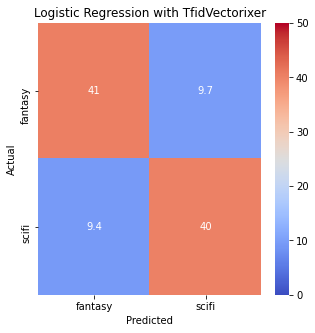

In [101]:
subreddits = ['fantasy', 'scifi']
fig = plt.figure(figsize=(5,5));
ax = fig.add_subplot(111);
preds_lrtvec = lr_tvec.predict(Xtvec_test)
probs_lrtvec = lr_tvec.predict_proba(Xtvec_test)
cm = confusion_matrix(y_test, preds_lrtvec)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Logistic Regression with TfidVectorixer');



Try the same LASSO and Ridge regularizations with this new vectorized data and newly fit model:

In [102]:
lr_tvec_lasso = LogisticRegressionCV(penalty= 'l1', solver= 'saga', Cs=[1], max_iter=1000,verbose=2)
lr_tvec_lasso.fit(Xtvec_train,y_train)
tvec_lasso_train = lr_tvec_lasso.score(Xtvec_train,y_train)
tvec_lasso_test = lr_tvec_lasso.score(Xtvec_test,y_test)
print(f'Train: {tvec_lasso_train}, Test: {tvec_lasso_test}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 82 epochs took 3 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


convergence after 211 epochs took 9 seconds
convergence after 135 epochs took 5 seconds
convergence after 68 epochs took 3 seconds
convergence after 61 epochs took 2 seconds


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.1s finished


convergence after 114 epochs took 7 seconds
Train: 0.8311892510005717, Test: 0.7828044596912521


In [103]:
lr_tvec_ridge = LogisticRegressionCV(penalty= 'l2', solver= 'saga', Cs=[0.1, 1, 10], max_iter=1000,verbose=2)
lr_tvec_ridge.fit(Xtvec_train,y_train)
tvec_ridge_train = lr_tvec_ridge.score(Xtvec_train,y_train)
tvec_ridge_test = lr_tvec_ridge.score(Xtvec_test,y_test)
print(f'Train: {tvec_ridge_train}, Test: {tvec_ridge_test}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
convergence after 58 epochs took 0 seconds
convergence after 23 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


convergence after 20 epochs took 0 seconds
convergence after 56 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 55 epochs took 1 seconds
convergence after 22 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 57 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 57 epochs took 1 seconds
convergence after 23 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


Train: 0.9182389937106918, Test: 0.8091766723842195


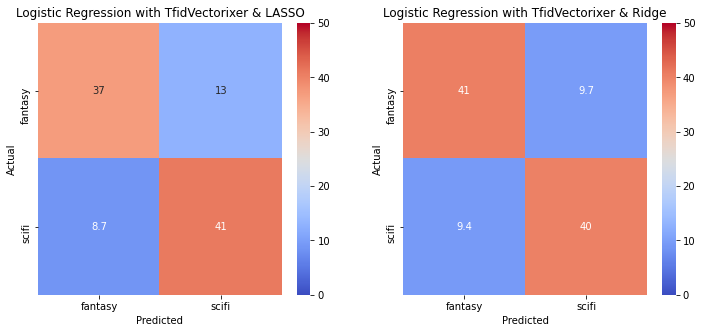

In [104]:
subreddits = ['fantasy', 'scifi']
fig = plt.figure(figsize=(12,5));
ax = fig.add_subplot(121);
preds_lrtvec_lasso = lr_tvec_lasso.predict(Xtvec_test)
probs_lrtvec_lasso = lr_tvec_lasso.predict_proba(Xtvec_test)
cm = confusion_matrix(y_test, preds_lrtvec_lasso)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Logistic Regression with TfidVectorixer & LASSO');

ax = fig.add_subplot(122);
preds_lrtvec_ridge = lr_tvec_ridge.predict(Xtvec_test)
probs_lrtvec_ridge = lr_tvec_ridge.predict_proba(Xtvec_test)
cm = confusion_matrix(y_test, preds_lrtvec_ridge)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Logistic Regression with TfidVectorixer & Ridge');





Neither LASSO nor Ridge appears to help, and using Tfid is not an improvement over CountVectorizer.

The only angle I don't think I've tried yet (of those we've learned) is stemming or lemmatizing.

First I just want to get an idea of what they do, to choose one over the other:

In [4]:
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

In [5]:
samples = ['I am computing at my computer all of this increasingly long day but I am getting sleepier every minute.',
          'The quick brown fox ran quickly over the hill and fell, hurting his furry head.',
          'I prefer Tolkein over Harry Potter, because Gandalf is a better wizard.']
my_tokenizer = RegexpTokenizer("[\w']+|\$[\d\.]+")


for my_string in samples:
    words = my_tokenizer.tokenize(my_string.lower())
    words_stem = [p_stemmer.stem(word) for word in words]
    words_lem  = [lemmatizer.lemmatize(word) for word in words]
    string_stem = ' '.join(words_stem)
    string_lem  = ' '.join(words_lem)
    print(f'Original  : {my_string}')
    print(f'Stemmed   : {string_stem}')
    print(f'Lemmatized: {string_lem}')


Original  : I am computing at my computer all of this increasingly long day but I am getting sleepier every minute.
Stemmed   : i am comput at my comput all of thi increasingli long day but i am get sleepier everi minut
Lemmatized: i am computing at my computer all of this increasingly long day but i am getting sleepier every minute
Original  : The quick brown fox ran quickly over the hill and fell, hurting his furry head.
Stemmed   : the quick brown fox ran quickli over the hill and fell hurt hi furri head
Lemmatized: the quick brown fox ran quickly over the hill and fell hurting his furry head
Original  : I prefer Tolkein over Harry Potter, because Gandalf is a better wizard.
Stemmed   : i prefer tolkein over harri potter becaus gandalf is a better wizard
Lemmatized: i prefer tolkein over harry potter because gandalf is a better wizard


Lemmatizing doesn't seem to have that much effect except to strip punctuation. So for the sake of looking for maximum impact, I'll try stemming on my data:

In [109]:
X_train_stem = pd.DataFrame([' '.join([p_stemmer.stem(word) for word in my_tokenizer.tokenize(string.lower())]) for string in list(X_train)])
X_test_stem  = pd.DataFrame([' '.join([p_stemmer.stem(word) for word in my_tokenizer.tokenize(string.lower())]) for string in list(X_test)])


In [110]:
X_train_stem['comment'] = X_train_stem[0]
X_train_stem.drop(columns = [0],inplace=True)
X_test_stem['comment'] = X_test_stem[0]
X_test_stem.drop(columns = [0],inplace=True)



Check to make sure it worked:

In [111]:
X_test.head()

9577     This review is a few months old, and that time...
17424    I know you’re looking for novels, but there’s ...
2978     [*Daniel Faust*](https://www.goodreads.com/boo...
13286    No, it's much worse and in no way related.\n\n...
13779    I thought he was absolutely brilliant on Power...
Name: comment, dtype: object

In [112]:
X_test_stem.head()

,comment
0,thi review is a few month old and that time it...
1,i know you re look for novel but there s a gre...
2,daniel faust http www goodread com book show 2...
3,no it' much wors and in no way relat worth a w...
4,i thought he wa absolut brilliant on powerless...


In [113]:
X_train_stem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13992 entries, 0 to 13991
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  13992 non-null  object
dtypes: object(1)
memory usage: 109.4+ KB


In [114]:
X_train2 = X_train_stem['comment']
X_test2  = X_test_stem['comment']

# Use TfidVectorizer:
tv = TfidfVectorizer(stop_words=stops)
tv.fit(X_train2,y_train)
Xtvec_stem_train = tv.transform(X_train2)
Xtvec_stem_test  = tv.transform(X_test2)

# instantuate, fit and run logistic regression:
lr_tvec_stem = LogisticRegression()
lr_tvec_stem.fit(Xtvec_stem_train,y_train)
lrtvec_stem_train = lr_tvec_stem.score(Xtvec_stem_train,y_train)
lrtvec_stem_test  = lr_tvec_stem.score(Xtvec_stem_test,y_test)
print(f'Train: {lrtvec_stem_train}, Test: {lrtvec_stem_test}')

Train: 0.90215837621498, Test: 0.8115351629502573


None of this seems to have helped, though it also didn't hurt much. Save the scores:

In [115]:
newscores = [

    {'model': 'Tfid + LR',  'train': lrtvec_train,   'test' : lrtvec_test},
    {'model': 'Tfid + LR + LASSO',  'train': tvec_lasso_train,   'test' : tvec_lasso_test},
    {'model': 'Tfid + LR + Ridge',  'train': tvec_ridge_train,   'test' : tvec_ridge_test},
    {'model': 'Stem + Tfid + LR',  'train': lrtvec_stem_train,  'test' : lrtvec_stem_test},
]
newscores_df = pd.DataFrame(newscores)
newscores_df['ndx'] = [17, 18, 19, 20]
newscores_df

,model,train,test,ndx
0,Tfid + LR,0.918239,0.809177,17
1,Tfid + LR + LASSO,0.831189,0.782804,18
2,Tfid + LR + Ridge,0.918239,0.809177,19
3,Stem + Tfid + LR,0.902158,0.811535,20


In [117]:
scores['ndx'] = range(17)
scores

,model,train,test,ndx
0,Baseline,0.501809,0.501909,0
1,NBayesian,0.829448,0.779184,1
2,LogReg,0.940715,0.814949,2
3,LogReg 5000,0.894628,0.801085,3
4,"LR with Lasso, a=1",0.892867,0.789237,4
5,"LR with Lasso, a=10",0.977844,0.796527,5
6,"LR with Ridge a=1 (ran 0.1, 1, 10)",0.951472,0.806389,6
7,"knn, k=1, uniform",0.993139,0.610206,7
8,"knn, k=3, uniform",0.766795,0.607847,8
9,"knn, k=5, uniform",0.761221,0.618997,9


In [119]:
scores_df= scores.append(newscores_df)
scores_df.set_index('ndx',inplace=True)
scores_df


,model,train,test
ndx,,,
0,Baseline,0.501809,0.501909
1,NBayesian,0.829448,0.779184
2,LogReg,0.940715,0.814949
3,LogReg 5000,0.894628,0.801085
4,"LR with Lasso, a=1",0.892867,0.789237
5,"LR with Lasso, a=10",0.977844,0.796527
6,"LR with Ridge a=1 (ran 0.1, 1, 10)",0.951472,0.806389
7,"knn, k=1, uniform",0.993139,0.610206
8,"knn, k=3, uniform",0.766795,0.607847


In [120]:
scores_df.sort_values(by='test',ascending=False)

,model,train,test
ndx,,,
2,LogReg,0.940715,0.814949
20,Stem + Tfid + LR,0.902158,0.811535
17,Tfid + LR,0.918239,0.809177
19,Tfid + LR + Ridge,0.918239,0.809177
6,"LR with Ridge a=1 (ran 0.1, 1, 10)",0.951472,0.806389
3,LogReg 5000,0.894628,0.801085
5,"LR with Lasso, a=10",0.977844,0.796527
4,"LR with Lasso, a=1",0.892867,0.789237
18,Tfid + LR + LASSO,0.831189,0.782804


In [121]:

scores_df.to_csv('./data/scores.csv')

### Further notebooks:

* project3_6: Random Forest models, because why not?

* project3_7: Enough modeling, time to visualize.



